<br>
<br>

![iteso](https://upload.wikimedia.org/wikipedia/en/5/5f/Western_Institute_of_Technology_and_Higher_Education_logo.png)

<strong>  InstitutoTecnológico y de Estudios Superiores de Occidente </strong>
<br />
<strong>  Maestría Ciencia de Datos  </strong>
<br />

# Modelado Predictivo: Aplicación SVR para costos de garantías de HP Inc. #

<br>
<br>

* * *

Daniel Nuño <br>
Profesor: Dr. Riemmann Ruiz Cruz <br>
Fecha entrega: 16 de octubre, 2022 <br>

* * *

<br>
<br>

## Definición del problema

Mes con mes la organización de finanzas, en conjunto la organización de Customer Support, debe proveer un estimado de los gastos y costos por garantías ejercidas que tendrá en el corto plazo, entre tres y doce meses. La solución actual deja que desear en cuanto la precisión, además de ser muy demandante en tiempo y personal.

Estas garantías son de las computadoras e impresoras de uso comercial y personal vendidos de HP en todo el mundo.
Geograficamente comprende 3 regiones y 10 mercados:

- America
    - Norte America
    - Latin America
- Europa, Africa y Medio Oriente
    - Reino unido
    - Europa Central
   - Europa Sur
   - Europa Noreste
   - Africa y Medio Oriente
- Asia Pacifico
    - China
    - Asia Mayor
    - India

En tipo de producto comprende 4 segmentos:

- Computadoras
    - Comercial - Business PC Solutions 
    - Consumo - Consumer PC
- Impresoras
    - Comercial - Office Printing Systems
    - Consumo - Home Printing Systems


El objetivo es crear una solución que pueda proveer una precisión, al menos, igual a las soluciones actuales, pero sin la bruma, el trabajo y el tiempo que conlleva hacerlo mes con mes. Idealmente será completamente automática, supervisada, online, pero hay consideraciones que no están capturadas en los datos, como información de partes altamente defectuosas, problemas en la cadena de suministro o inversiones.

Estas estimaciones en conjunto de otra información o estimaciones proporcionado por otras organizaciones tienen tres propositos principales que se usan internamente:<br>
- Estimación del flujo de efectivo.
- Estimación de los estados financieros de la empresa.
- Responsabilidad a los altos ejecutivos.

Parte de la visión de HP Inc es la innovación digital e internamente transformar la forma en que trabajamos. El métrico principal es la precisión de la predicción evaluado mes con mes, es decir la diferencia entre predicción y real. El benchmark es la precisión de la solución actual. Adicional, métricos relevantes son (1) cuantos días de laborales se puede reducir para la entrega de la predicción. Si ahora tarda un ciclo de 10 días en entregar entonces que tarde menos de 10 días. Y (2) cuantas horas de trabajo se reducen mes con mes, trabajo en horas por trabajador para entregar la predicción de gastos y costos.

Actualmente esta tarea tiene un costo inherte a la labor de todos los que participan que teoricamente puede reducirse con una nueva implementación. La solución no debe canjear precisión por costo, sino que, por lo menos, la precisión debe ser la misma.

Los costos y gastos se reportan mes con mes y se componen de costos regionales, gastos globales, y reservas y amortizaciones. Los costos globales son en su mayoría fijos relacionados a empleados o inversiones. Las reservas y amortizaciones responden a ahorros hechos para cubrir los costos basados en las ventas. Los costos regionales corresponden a costos fijos de empleados, pero también a gastos variables operativos como partes de repuesto, cadena de suministro, logistica, trabajo de ingenieros en la reparación, y llamadas de asistencia.

- Net Revenue 
    - Total Warranty Expense
        - Region Owned Expense
            - Variable Expense
                - Contact Center Expense
                - Delivery
                - Supply Chain
            - Repair OH Expense
                - Delivery OH
                - Supply Chain OH
        - Worldwide Owned and Allocated Expense
            - CS HQ Owned and Allocated
            - GBU Owned and Allocated

## Preparacion de los datos

Los datos a útilizar son los costos mensuales de cada una de las variables que componen operativamente la organización de garantías. En cuanto al rango, los datos disponibles son de Noviembre 2016 a Julio 2022. Los datos financieros son son consolidados en una base de datos, por lo tanto no se les aplico mucho tratamiento más que etiquetado de datos y codificación de los valores para proteger la confidencialidad de HP.

Para este trabajo, el enfoqué sera para el mercado de Norte America y las computadoras comerciales.

In [127]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics.pairwise import (linear_kernel,polynomial_kernel,rbf_kernel)
from sklearn.metrics import mean_squared_error as mse, r2_score
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

raw_data = pd.read_excel('dataset.xlsx', 'na_bps')

In [128]:
data = raw_data.copy()
data.month = data.month + '-01'
data['month'] = pd.to_datetime(data['month'])
data.account = data['account'].astype('str')
data = data.pivot(index=['month'], columns=['account'], values=['total'])
data = data.droplevel(0, axis=1)

X_periods = np.arange(len(data)).reshape(-1,1)

data_index = pd.date_range(start=data.index.min(),
                            end=data.index.max(),
                            freq='M')

data = data.fillna(axis=1, method='backfill')

test_data = data.loc[["2022-06-01", "2022-07-01"]]

train_index = set(data.index) - set(test_data.index)
train_data = data.loc[list(train_index)]
train_data = train_data.sort_index()

scaler = MinMaxScaler()
scaler.fit(train_data)
data_scale = scaler.transform(data)
data_scale = pd.DataFrame(data_scale, columns=data.columns, index=data.index)

Para separar los datos entre entrenamiento y prueba voy y ya que es una serie de tiempo, voy a dejar los últimos dos valores para hacer la prueba. Estos últimos dos valores no son parte del fit para *MinMaxScaler* ni como parte del entrenamiento.

La siguiente gráfica podemos ver el comportamiento de los datos y validar el efecto de la normalización.

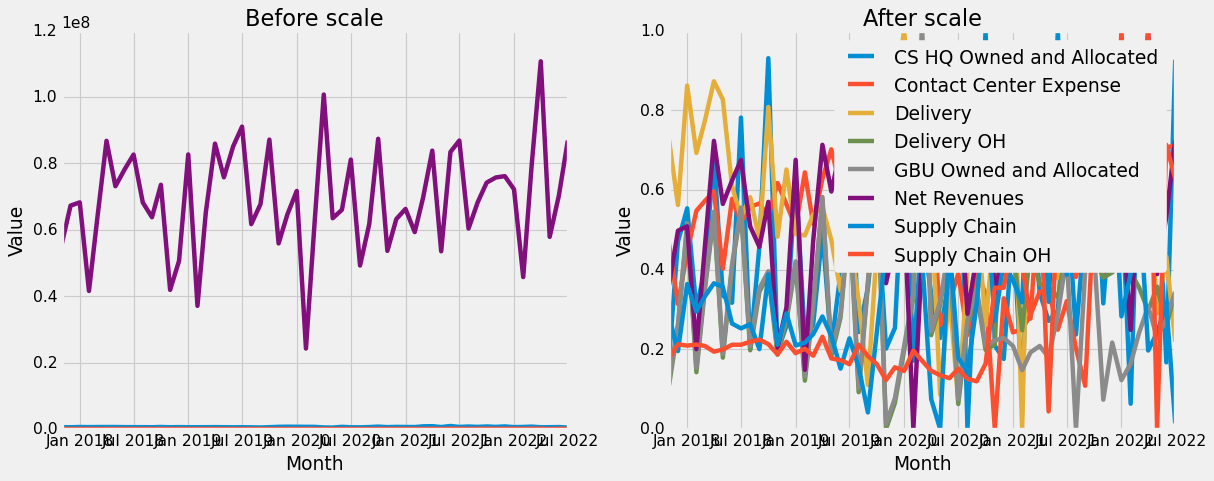

In [129]:
fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(data)
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Before scale')

plt.subplot(1,2,2)
plt.plot(data_scale)
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('After scale')
plt.legend(data.columns)
plt.show()

### Ingeniería de características para encontrar el mejor conjunto de datos

Ya que para esta serie de tiempo no tenemos más variables dependientes que expliquen el comportamiento, queremos encontrar las características que generen el mejor modelo. Para esto vamos a comparar los data sets con la máquina de soporte lineal. Posteriormente que seleccionemos un conjunto de datos, vamos a comparar con los demás modelos de máquina de soporte y Kernels.

La cuenta para realizar esta investigación es **Supply Chain**.

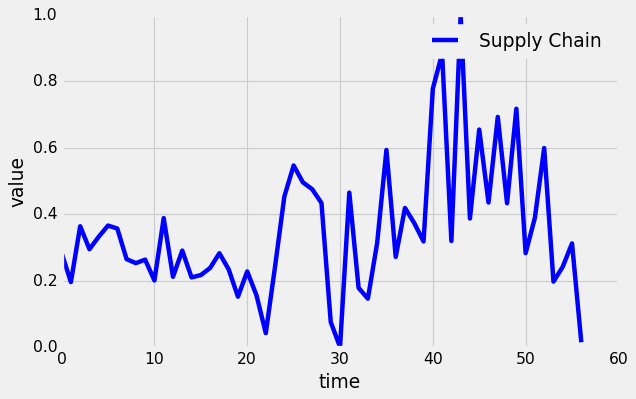

In [131]:
cuenta_base = 'Supply Chain'
y = data_scale[cuenta_base].values.ravel()
X = X_periods

plt.figure(figsize=(8,5))
plt.plot(X, y, c='b', label=cuenta_base)
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

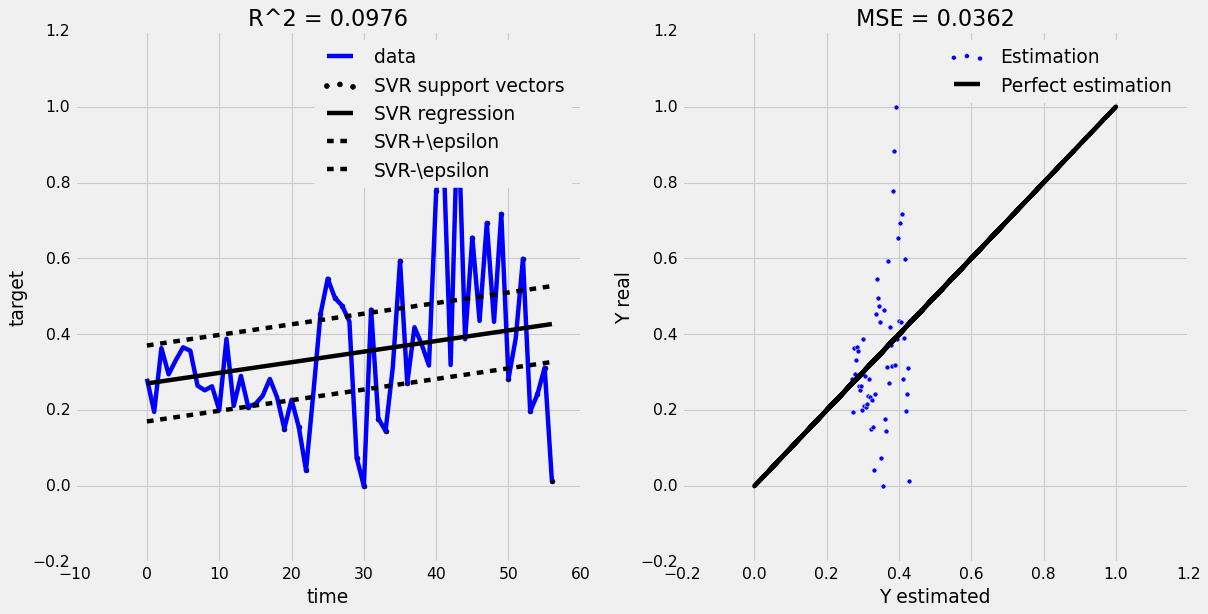

In [132]:
def compare_svr(X, y, test_window, kernel, epsilon, gamma, degree, do_plot='No'):
    if test_window == 0:
        # params
        #epsilon = 0.1
        #kernel = 'linear'
        #gamma = 'auto'
        #degree = 3
        
        # kernel transformation
        if kernel == 'linear':
            K_x = linear_kernel(X)
        elif kernel == 'rbf':
            K_x = rbf_kernel(X)
        else:
            K_x = polynomial_kernel(X)

        # creating a SVR model class
        model_svr = SVR(kernel=kernel, epsilon=epsilon, gamma=gamma, degree=degree)
        # Step 2. Training the model
        model_svr.fit(X, y)
        # Step 3. Using the model
        y_hat = model_svr.predict(X)
        # Step 4. Evaluation of results
        sv_x = model_svr.support_
        R2 = model_svr.score(X,y)
        Y_plot = model_svr.predict(X)

        #%% Prediction using the optimization problem results.
        alphas = model_svr.dual_coef_
        x_sv = model_svr.support_vectors_
        b = model_svr.intercept_
        # Needs the correct Kernel
        if kernel == 'linear':
            K_x = linear_kernel(x_sv, X)
        elif kernel == 'rbf':
            K_x = rbf_kernel(x_sv, X)
        else:
            K_x = polynomial_kernel(x_sv, X)

        Y_p = np.dot(alphas, K_x) + b

        if do_plot == 'Yes':
            if X.shape[1] == 1:
                # View the results
                fig = plt.figure(figsize=(16,8))
                plt.subplot(1,2,1)
                plt.plot(X, y, c='b', label='data')
                plt.scatter(X[sv_x], y[sv_x], c='k', label='SVR support vectors', zorder=1,edgecolors=(0, 0, 0))
                plt.plot(X, Y_plot, c='k',label='SVR regression')
                plt.plot(X, Y_plot+epsilon, c='k', linestyle='dashed',label='SVR+\epsilon')
                plt.plot(X, Y_plot-epsilon, c='k', linestyle='dashed',label='SVR-\epsilon')
                plt.xlabel('time')
                plt.ylabel('target')
                plt.title('R^2 = %0.4f'%model_svr.score(X,y))
                plt.legend()

                plt.subplot(1,2,2)
                plt.scatter(y_hat, y, c='b', label='Estimation')
                plt.plot(y, y, c='k', label='Perfect estimation')
                plt.xlabel('Y estimated')
                plt.ylabel('Y real')
                plt.title('MSE = %0.4f'%mse(y, y_hat))
                plt.legend()
                plt.show()
            else:
                # View the results
                plt.figure(figsize=(7,5))
                plt.scatter(y_hat, y, c='b', label='Estimation')
                plt.plot(y, y, c='k', label='Perfect estimation')
                plt.xlabel('Y estimated')
                plt.ylabel('Y real')
                plt.title('SVM ' + kernel + ' K |MSE = %0.4f'%mse(y, y_hat) + ' | R^2 = %0.4f'%model_svr.score(X,y))
                plt.legend()
                plt.show()
        
        return mse(y, y_hat), model_svr.score(X,y)
    
    #split test and train
    else:
        X_train = X[:-test_window]
        X_test = X[len(X) - test_window:]
        y_train = y[:-test_window]
        y_test = y[len(y) - test_window:]
        
        # creating a SVR model class
        model_svr = SVR(kernel=kernel, epsilon=epsilon, gamma=gamma, degree=degree)
        # Training the model
        model_svr.fit(X_train, y_train)
        #Using the model
        y_hat = model_svr.predict(X_test)
        #return train and test model accuracy
        R2_train = r2_score(y_train, model_svr.predict(X_train))
        mse_mtrc_train = mse(y_train, model_svr.predict(X_train))
        R2_test = r2_score( y_test, y_hat)
        mse_mtrc_test = mse(y_test, y_hat)

        if do_plot == 'Yes':
            plt.figure()
            plt.scatter(x=range(len(X_train)), y=y_train, c='b', label='train', s=20)
            plt.scatter(x=range(len(X)-test_window,len(X)), y=y_test, c='g', label='test', s=40)
            plt.scatter(x=range(len(X)-test_window,len(X)), y=y_hat, c='r', label='estimated', s=40)
            plt.xlabel('period month')
            plt.ylabel('value')
            plt.title('LS ' + kernel + ' K |MSE = %0.3f'%mse(y_test, y_hat) + ' |R^2 = %0.3f'%r2_score(y_test, y_hat))
            plt.legend()
            plt.show()

        # return train and test metrics
        return mse_mtrc_train, R2_train, mse_mtrc_test, '%0.2f'%R2_test

_, _ = compare_svr(X, y, 0 , 'linear', 0.1, 'auto', 3, do_plot='Yes')

No muy buenos resultados usando una variable.
Ahora, podemos usar las otras cuentas como variables independientes, de manera que tendríamos 9 variables independientes.

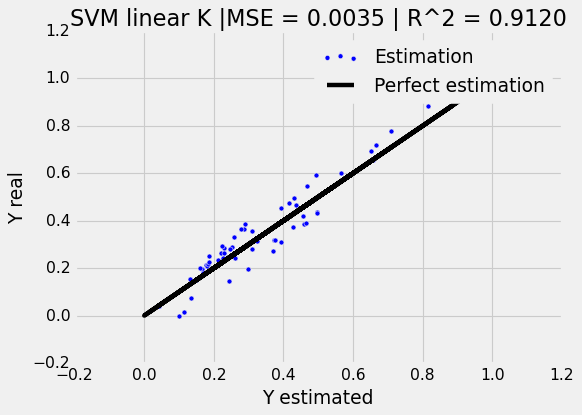

In [133]:
y = data_scale[cuenta_base].values.ravel()
X = data_scale[list(set(data_scale.columns) - set(cuenta_base))].values
X = np.column_stack((X, X_periods))
_, _ = compare_svr(X, y, 0, 'linear', 0.1, 'auto', 3, do_plot='Yes')

Tiene resultados bastante buenos. De hecho, si modificas épsilon para reducir el slack puedes alcanzar una regresión casi perfecta. Podría suponer un sobreajuste.
Puede también indicar que la correlación, en ese sentido el movimiento de las otras cuentas afecta mucho en el resultado.

Ahora, una pregunta fundamenta es ¿los valores pasados de mi regresión afectan el resultado actual? para comprobarlo podemos ajustar X como rezagos de la variable a predecir.
$$ X_t = y_{t-1}, y_{t-2} $$

El razonamiento para elegir los dos valores anteriores es porque hablando de contabilidad, es la norma que se maneje por ciclos de tres meses.
Es posible que tengan autocorrelación en ese ciclo, por lo tanto, podríamos esperar que los meses previos tengan efecto en el valor actual. Ahora tenemos 11 variables y 55 observaciones.

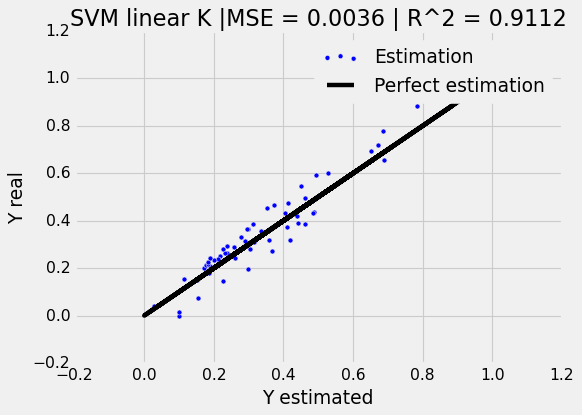

In [134]:
timesteps = 3
train_data = data_scale[cuenta_base].values.reshape(-1, 1)
train_data_timesteps = np.array([[j for j in train_data[i:i+timesteps]]
                                    for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

X, y = train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,[timesteps-1]]
y = y.ravel()
X_others = data_scale[list(set(data_scale.columns) - set(cuenta_base))].values[timesteps-1:,:]
X = np.column_stack((X_periods[timesteps-1:], X, X_others))
_, _ = compare_svr(X, y, 0, 'linear', 0.1, 'auto', 3, do_plot='Yes')

Los resultados de ajuste y error empeoraron ligeramente comparado con el data set pasado.

Ya que en la realidad no podemos utilizar los datos en $t$ de otras cuentas para predecir de la cuenta objetivo $t$, porque ya es muy tarde. Lo que podemos hacer es utilizar el periodo anterior $ X_{t-1} $ de las demás variables independientes para estimar $ y_{t} $

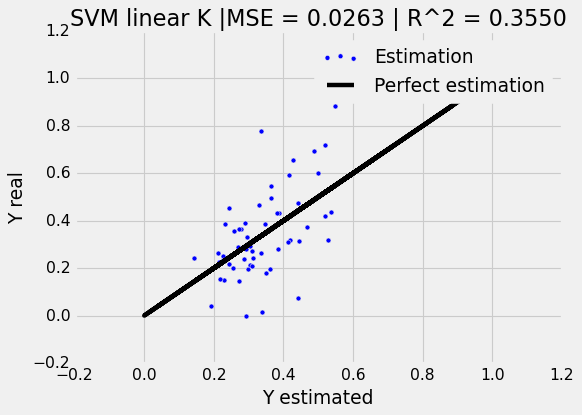

In [135]:
y = data_scale[cuenta_base].values[1:]
y = y.ravel()
X_others = data_scale[list(set(data_scale.columns) - set(cuenta_base))].values[:-1,:]
X = np.column_stack((X_periods[1:], X_others))
_, _ = compare_svr(X, y, 0, 'linear', 0.1, 'auto', 3, do_plot='Yes')

Usualmente los meses que también son fin de cuarto tiene mayor relevancia en los resultados. Puede ser por cuestiones operativas, de mercado, o incluso de ventas. Es por eso que si tenemos una variable categórica que pueda indicar el periodo que indica el fin de cuarto entonces es posible que para los datos sea lo suficientemente relevante.

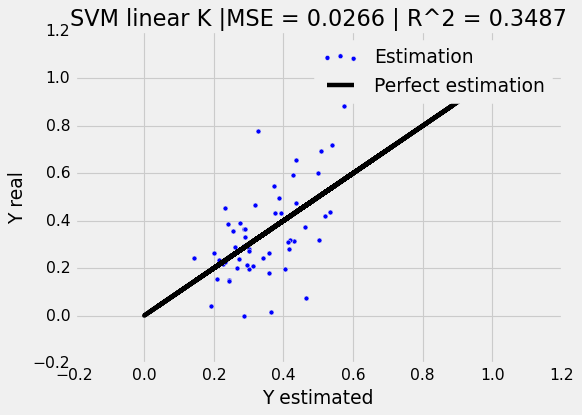

In [136]:
y = data_scale[cuenta_base].values[1:]
y = y.ravel()
X_others = data_scale[list(set(data_scale.columns) - set(cuenta_base))].values[:-1,:]
X_q = [1 if x%3 == 0 else 0 for x in range(len(X_periods))]
X_q = np.array(X_q[1:])
X = np.column_stack((X_periods[1:], X_others, X_q))
_, _ = compare_svr(X, y, 0, 'linear', 0.1, 'auto', 3, do_plot='Yes')

El data set que usa las otras cuentas como variable exógena tiene la mejor precisión, casi perfecta. Sin embargo, es muy improbable que funcione en la realidad por que, para cualquier mes, cuando tu tienes la variable los valores de las variables exógenas es muy tarde para predecir la variable dependiente.

El data set que arrojo los mejores resultados y que se puede usar para pronosticar el siguiente periodo es el que incluye las otras cuentas rezagadas en un periodo, más la variable categórica que indica el fin de cuarto.

Ahora que sabemos que características funcionan mejor para nuestro modelo, podemos evaluar y comparar cada una de las implementaciones de regresores en máquinas de soporte. Y lo mismo para cada una de las cuentas de nuestro interés.

Las implementaciones que evaluaremos es la librería **Sklearn.smv.SVR con kernel lineal, rbf y polinomial**.

Para **LS-SVM**, el doctor en física Danny Vanpoucke realizó una implementación basada en los modelos de sklearn para un regresor. Eso significa que su implementación es muy parecida y compatible con los modelos de sklearn. El siguiente código es la clase LS-SVM.

## Modelo de regresión

In [137]:
def build_data_sets(acc):
    #arrange y and X
    y = data_scale[acc].values[1:]
    y = y.ravel()
    X_others = data_scale[list(set(data_scale.columns) - set(acc))].values[:-1,:]
    X_q = [1 if x%3 == 0 else 0 for x in range(len(X_periods))]
    X_q = np.array(X_q[1:])
    X = np.column_stack((X_periods[1:], X_others, X_q))

    return X, y

In [138]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 19 09:27:21 2020
An LS-SVM regression class following the sk-learn API.
_                         _   _   _    _  _
| 0          1^T_N         |  | b  |   | 0 |
|                          |  |    | = |   |
| 1_N  Omega+gamma^-1 I_N  |  | a  |   | Y |
|_                        _|  |_  _|   |_ _|
Omega= Kernel K(x_i,x_j)
gamma= hyper-parameter (is a ratio z/µ with z the sum squared error and µ the
                        amount of regularization)
1_N = vector (1,1,1,..,1)
I_N = NxN unity matrix
@author: Dr. Dr. Danny E. P. Vanpoucke
@web   : https://dannyvanpoucke.be
"""
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin


class LSSVMRegression(BaseEstimator, RegressorMixin):
    """
    An Least Squared Support Vector Machine (LS-SVM) regression class, build
    on the BaseEstimator and RegressorMixin base classes of sklearn.
    (Let's hope furture upgrades of python sk-learn just doesn't break this...
    consider this a python feature)
    Attributes:
        - gamma : the hyper-parameter (float)
        - kernel: the kernel used     (string)
        - kernel_: the actual kernel function
        - x : the data on which the LSSVM is trained (call it support vectors)
        - y : the targets for the training data
        - coef_ : coefficents of the support vectors
        - intercept_ : intercept term
    """
    def __init__(self, gamma: float = 1.0, kernel: str = None, c: float = 1.0,
                 d: float = 2, sigma: float = 1.0):
        """
        Create a new regressor
        Parameters:
            - gamma: floating point value for the hyper-parameter gamma, DEFAULT=1.0
            - kernel: string indicating the kernel: {'linear','poly','rbf'}, DEFAULT='rbf'
            - the kernel parameters
                    * linear: none
                    * poly:
                        + c: scaling constant, DEFAULT=1.0
                        + d: polynomial power, DEFAULT=2
                    * rbf:
                        + sigma: scaling constant, DEFAULT=1.0
        """
        self.gamma = gamma
        self.c = c
        self.d = d
        self.sigma = sigma
        if kernel is None:
            self.kernel = 'rbf'
        else:
            self.kernel = kernel

        params = dict()
        if kernel == 'poly':
            params['c'] = c
            params['d'] = d
        elif kernel == 'rbf':
            params['sigma'] = sigma

        self.kernel_ = LSSVMRegression.__set_kernel(self.kernel, **params)

        #model parameters
        self.x = None
        self.y = None
        self.coef_ = None
        self.intercept_ = None

    def get_params(self, deep=True):
        """
            The get_params functionality provides the parameters of the LSSVMRegression class.
            These exclude the modelparameters.
        """
        return {"c": self.c, "d": self.d, "gamma": self.gamma,
                "kernel": self.kernel, "sigma":self.sigma}

    def set_params(self, **parameters):
        """
            Set the parameters of the class. Important note: This should do
            anything that is done to relevant parameters in __init__ as
            sklearn's GridSearchCV uses this instead of init.
            More info:  https://scikit-learn.org/stable/developers/develop.html
        """
        #print("SETTING PARAMETERS IN LSSVM:",parameters.items())

        for parameter, value in parameters.items():
            #setattr should do the trick for gamma,c,d,sigma and kernel
            setattr(self, parameter, value)
        #now also update the actual kernel
        params = dict()
        if self.kernel == 'poly':
            params['c'] = self.c
            params['d'] = self.d
        elif self.kernel == 'rbf':
            params['sigma'] = self.sigma
        self.kernel_ = LSSVMRegression.__set_kernel(self.kernel, **params)

        return self

    def set_attributes(self, **parameters):
        """
            Manually set the attributes of the model. This should generally
            not be done, except when testing some specific behaviour, or
            creating an averaged model.
            Parameters are provided as a dictionary.
                - 'intercept_' : float intercept
                - 'coef_'      : float array of coefficients
                - 'support_'   : array of support vectors, in the same order sorted
                                 as the coefficients
        """
        #not the most efficient way of doing it...but sufficient for the time being
        for param, value in parameters.items():
            if param == 'intercept_':
                self.intercept_ = value
            elif param == 'coef_':
                self.coef_ = value
            elif param == 'support_':
                self.x = value

    @staticmethod
    def __set_kernel(name: str, **params):
        """
            Internal static function to set the kernel function.
            NOTE: The second "vector" xj will be the one which generally
                  contains an array of possible vectors, while xi should be a single
                  vector. Therefore, the numpy dot-product requires xj to
                  be transposed.
            The kernel returns either a scalar or a numpy nd-array of
            rank 1 (i.e. a vector), if it returns something else the result
            is wrong if xi is an array.
        """
        def linear(xi, xj):
            """
               v*v=scal (dot-product OK)
               v*m=v    (dot-product OK)
               m*m=m    (matmul for 2Dx2D, ok with dot-product)
            """
            return np.dot(xi, xj.T)

        def poly(xi, xj, c=params.get('c', 1.0), d=params.get('d', 2)):
            """
                Polynomial kernel ={1+ (xi*xj^T)/c }^d
                Parameters:
                    - c: scaling constant, DEFAULT=1.0
                    - d: polynomial power, DEFAULT=2
                    - xi and xj are numpy nd-arrays
                (cf: https://en.wikipedia.org/wiki/Least-squares_support-vector_machine )
                works on same as linear
            """
            return ((np.dot(xi, xj.T))/c  + 1)**d

        def rbf(xi, xj, sigma=params.get('sigma', 1.0)):
            """
            Radial Basis Function kernel= exp(- ||xj-xi||² / (2*sigma²))
            In this formulation, the rbf is also known as the Gaussian kernel of variance sigma²
            As the Euclidean distance is strict positive, the results of this kernel
            are in the range [0..1] (x € [+infty..0])
            Parameters:
                - sigma: scaling constant, DEFAULT=1.0
                - xi and xj are numpy nd-arrays
            (cf: https://en.wikipedia.org/wiki/Least-squares_support-vector_machine )
            Possible combinations of xi and xj:
                vect & vect   -> scalar
                vect & array  -> vect
                array & array -> array => this one requires a pair distance...
                                    which can not be done with matmul and dot
                The vectors are the rows of the arrays (Arr[0,:]=first vect)
                The squared distance between vectors= sqr(sqrt( sum_i(vi-wi)² ))
                --> sqr & sqrt cancel
                --> you could use a dot-product operator for vectors...but this
                seems to fail for nd-arrays.
            For vectors:
                ||x-y||²=sum_i(x_i-y_i)²=sum_i(x²_i+y²_i-2x_iy_i)
                --> all products between vectors can be done via np.dot: takes the squares & sum
            For vector x and array of vectors y:
                --> x²_i : these are vectors: dot gives a scalar
                --> y²_i : this should be a list of scalars, one per vector.
                            => np.dot gives a 2d array
                            => so   1) square manually (squares each element)
                                    2) sum over every row (axis=1...but only in case we
                                                           have a 2D array)
                --> x_iy_i : this should also be a list of scalars. np.dot does the trick,
                            and even gives the same result if matrix and vector are exchanged
            for array of vectors x and array of vectors y:
                --> either loop over vectors of x, and for each do the above
                --> or use cdist which calculates the pairwise distance and use that in the exp
            """
            from scipy.spatial.distance import cdist

           # print('LS_SVM DEBUG: Sigma=',sigma,'  type=',type(sigma) )
           # print('              xi   =',xi,'  type=',type(xi))
           # print('              xj   =',xj,'  type=',type(xj))


            if (xi.ndim == 2 and xi.ndim == xj.ndim): # both are 2D matrices
                return np.exp(-(cdist(xi, xj, metric='sqeuclidean'))/(2*(sigma**2)))
            elif ((xi.ndim < 2) and (xj.ndim < 3)):
                ax = len(xj.shape)-1 #compensate for python zero-base
                return np.exp(-(np.dot(xi, xi) + (xj**2).sum(axis=ax)
                                - 2*np.dot(xi, xj.T))/(2*(sigma**2)))
            else:
                message = "The rbf kernel is not suited for arrays with rank >2"
                raise Exception(message)

        kernels = {'linear': linear, 'poly': poly, 'rbf': rbf}
        if kernels.get(name) is not None:
            return kernels[name]
        else: #unknown kernel: crash and burn?
            message = "Kernel "+name+" is not implemented. Please choose from : "
            message += str(list(kernels.keys())).strip('[]')
            raise KeyError(message)

    def __OptimizeParams(self):
        """
        Solve the matrix operation to get the coefficients.
        --> equation 3.5 and 3.6 of the book by Suykens
        ==> that is for classification, for regression slightly different cf Dilmen paper 2017
        self.y: 1D array
        self.X: 2D array (with rows the vectors: X[0,:] first vector)
        Set the class parameters:
            - self.intercept_ : intercept
            - self.coef_      : coefficients
        """
        #eq 3.6: Omega_kl = y_ky_lK(x_k,x_l)
        # !! note that the product of a vector and the transposed is a dot-product
        #    and we need an outer product
        #For classification and Regression, the matrices are slightly different...
        # (why? except for what came out of solving equations?
        # Dilmen et al, IFAC PapersOnline 50(1), 8642-8647 (2017))

        # Classification
        # Omega = np.multiply( np.multiply.outer(y,y), self.kernel_(X,X) ) # correct version
        #A_dag = np.linalg.pinv(np.block([
        #    [0,                           y.T                   ],
        #    [y,   Omega + self.gamma**-1 * np.eye(len(y_values))]
        #])) #need to check if the matrix is OK--> y.T parts
        #B = np.array([0]+[1]*len(y_values))

        #Regression
        Omega = self.kernel_(self.x, self.x)
        Ones = np.array([[1]]*len(self.y)) # needs to be a 2D 1-column vector, hence [[ ]]

        A_dag = np.linalg.pinv(np.block([
            [0,                           Ones.T                      ],
            [Ones,   Omega + self.gamma**-1 * np.identity(len(self.y))]
        ])) #need to check if the matrix is OK--> y.T parts
        B = np.concatenate((np.array([0]), self.y), axis=None)

        solution = np.dot(A_dag, B)
        self.intercept_ = solution[0]
        self.coef_      = solution[1:]


    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the parameters based on the support vectors X (and store these as they are
        parameters of the LS-SVM as well, because needed for prediction)
        We are doing Regression.
        Parameters:
            - X : 2D array of vectors (1 per row: X[0,:] first vector)
            - y : 1D vector of targets
        """

        #print("IN FIT==> GAMMA=",self.gamma,"  SIGMA=",self.sigma)

        if isinstance(X, (pd.DataFrame, pd.Series)): #checks if X is an instance of either types
            Xloc = X.to_numpy()
        else:
            Xloc = X

        if isinstance(y, (pd.DataFrame, pd.Series)):
            yloc = y.to_numpy()
        else:
            yloc = y

        #check the dimensionality of the input
        if (Xloc.ndim == 2) and (yloc.ndim == 1):
            self.x = Xloc
            self.y = yloc
            self.__OptimizeParams()
        else:
            message = "The fit procedure requires a 2D numpy array of features "\
                "and 1D array of targets"
            raise Exception(message)

    def predict(self, X: np.ndarray)->np.ndarray:
        """
        Predict the regression values for a set of feature vectors
        Parameters:
            - X: ndarray of feature vectors (max: 2D), 1 per row if more than one.
        """
        Ker = self.kernel_(X, self.x) #second component should be the array of training vectors
        Y = np.dot(self.coef_, Ker.T) + self.intercept_
        return Y

In [139]:
def compare_lssvm(X, y, test_window, kernel, gamma, d, do_plot='No'):
    #no split
    if test_window == 0:
        # params

        # creating a SVR model class
        model_svr = LSSVMRegression(kernel=kernel, gamma=gamma, d=d)
        # Step 2. Training the model
        model_svr.fit(X, y)
        # Step 3. Using the model
        y_hat = model_svr.predict(X)
        # Step 4. Evaluation of results
        sv_x = model_svr.coef_
        R2 = r2_score(y, y_hat)
        mse_mtrc = mse(y, y_hat)
        if do_plot == 'Yes':
            # View the results
            plt.figure(figsize=(7,5))
            plt.scatter(y_hat, y, c='b', label='Estimation')
            plt.plot(y, y, c='k', label='Perfect estimation')
            plt.xlabel('Y estimated')
            plt.ylabel('Y real')
            plt.title('LS ' + kernel + ' K |MSE = %0.4f'%mse(y, y_hat) + ' |R^2 = %0.4f'%r2_score(y, y_hat))
            plt.legend()
            plt.show()
        
        return mse_mtrc, R2
    
    #split test and train
    else:
        X_train = X[:-test_window]
        X_test = X[len(X) - test_window:]
        y_train = y[:-test_window]
        y_test = y[len(y) - test_window:]
        
        # creating a SVR model class
        model_svr = LSSVMRegression(kernel=kernel, gamma=gamma, d=d)
        # Training the model
        model_svr.fit(X_train, y_train)
        #Using the model
        y_hat = model_svr.predict(X_test)
        #return train and test model accuracy
        sv_x = model_svr.coef_
        R2_train = r2_score(y_train, model_svr.predict(X_train))
        mse_mtrc_train = mse(y_train, model_svr.predict(X_train))
        R2_test = r2_score( y_test, y_hat)
        mse_mtrc_test = mse(y_test, y_hat)

        if do_plot == 'Yes':
            plt.scatter(x=range(len(X_train)), y=y_train, c='b', label='train', s=20)
            plt.scatter(x=range(len(X)-test_window,len(X)), y=y_test, c='g', label='test', s=40)
            plt.scatter(x=range(len(X)-test_window,len(X)), y=y_hat, c='r', label='estimated', s=40)
            plt.xlabel('period month')
            plt.ylabel('value')
            plt.title('LS ' + kernel + ' K |MSE = %0.3f'%mse(y_test, y_hat) + ' |R^2 = %0.3f'%r2_score(y_test, y_hat))
            plt.legend()
            plt.show()

        # return train and test metrics
        return mse_mtrc_train, R2_train, mse_mtrc_test, '%0.2f'%R2_test

La evaluación del modelo será con $R^2$ y $MSE$ el error medio al cuadrado. Pero, primero la introducción a cada unos de las formulaciones y los kernels ya despues hacemos la separación para prueba.

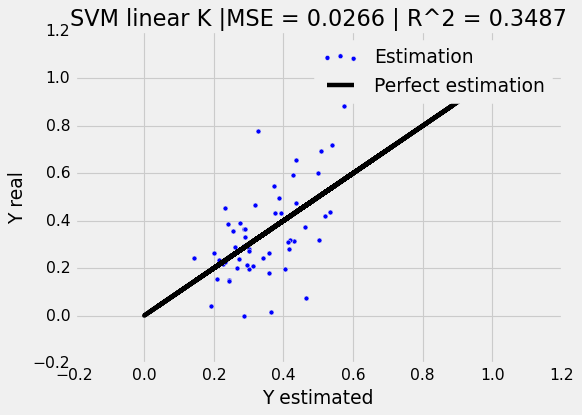

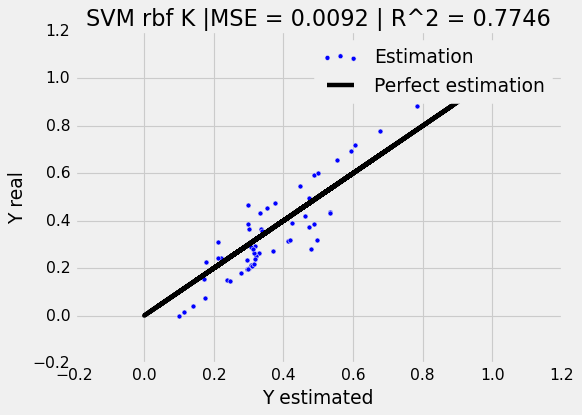

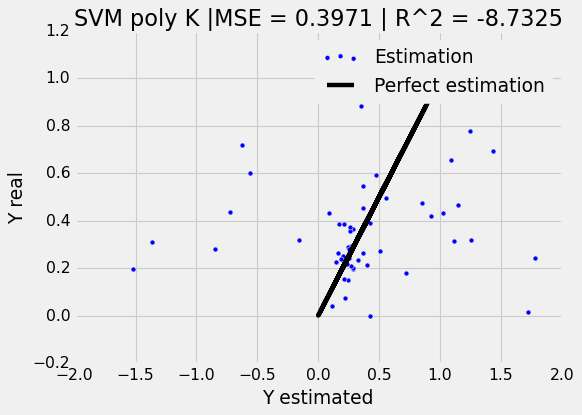

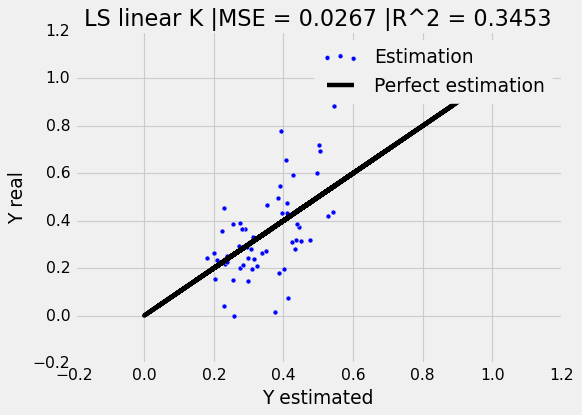

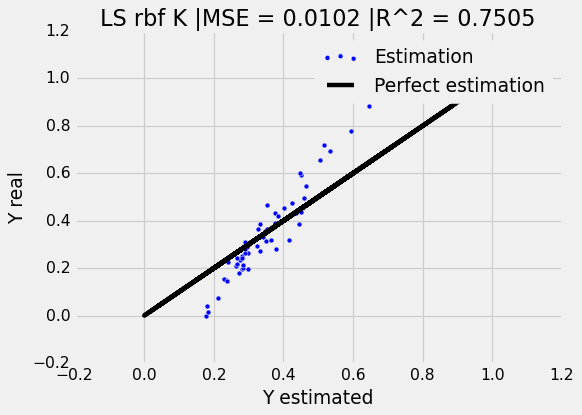

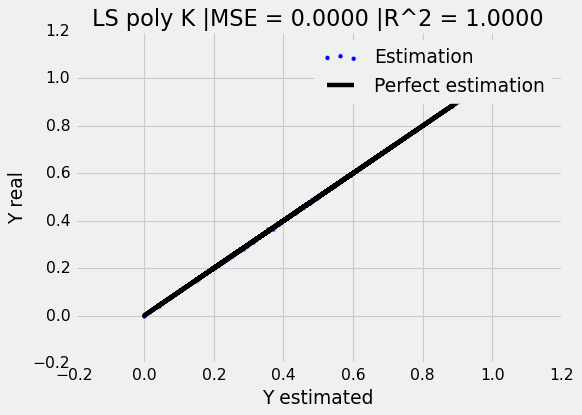

In [140]:
_, _ = compare_svr(X, y, 0, 'linear', 0.1, 'auto', 4, 'Yes')
_, _ = compare_svr(X, y, 0, 'rbf', 0.1, 'auto', 4, 'Yes')
_, _ = compare_svr(X, y, 0, 'poly', 0.1, 'auto', 3, 'Yes')
_, _ = compare_lssvm(X, y, 0, 'linear', 1, 4, 'Yes')
_, _ = compare_lssvm(X, y, 0, 'rbf', 1, 4, 'Yes')
_, _ = compare_lssvm(X, y, 0, 'poly', 1, 4, 'Yes')

Se puede apreciar el comportamiento del kernel lineal es similar a lo que esperaríamos en una regresión lineal con errores no auto correlacionados y posiblemente normalizados.

Pero definitivamente el resultado que llama más la atención es LS - SVM, con Kernel polinomial, de potencia 4, arroja sorprendentemente buenos resultados. Parece que hay un error pero vamos a analizar más a fondo los resultados observando la transformación dependiendo el grado el polinomio. Ahora si, ya seperamos para entrenamiento y prueba.

In [141]:
mse_ls = []
r2_ls = []
mse_ls_tst = []
r2_ls_tst = []
grado = []
for i in range(2,9):
    mse_ls_i, r2_ls_i, mse_ls_tst_i, r2_ls_tst_i = compare_lssvm(X, y, 2, 'poly', gamma=1, d=i)
    mse_ls.append(mse_ls_i)
    r2_ls.append(r2_ls_i)
    mse_ls_tst.append(mse_ls_tst_i)
    r2_ls_tst.append(r2_ls_tst_i)
    grado.append(i)

ls_poly_test = np.column_stack((grado,mse_ls, r2_ls, mse_ls_tst, r2_ls_tst))
ls_poly_test = pd.DataFrame(ls_poly_test, columns=['Grado', 'MSE Train', 'R2 Train', 'MSE Test', 'R2 Test'])
ls_poly_test

,Grado,MSE Train,R2 Train,MSE Test,R2 Test
0,2,0.014413136897247754,0.6408475113326302,0.23765077790232533,-9.73
1,3,0.00022798851281366812,0.994318888223407,0.5849660520548985,-25.40
2,4,1.6404226779358462e-06,0.9999591232712596,760.7476243510694,-34336.20
3,5,0.0019401977069182727,0.951653353470924,54525.58703193449,-2461072.70
4,6,0.0069166002823910396,0.8276493020049975,204565.7527349638,-9233304.35
5,7,0.010737955829715628,0.7324271886865179,333046.60382732365,-15032432.09
6,8,0.017687785177739317,0.5592484751316038,986523.5861217745,-44527850.74


La previa tabla muestra que el grado del polinomio 2 es ya bastante acertado a un $R^2$ 0.64. Y el $R^2$ sigue mejorando hasta el grado 4 donde esta básicamente perfecto. Después de eso comienza de decadencia, y en el grado 8 el $R^2$ ya es solo de la mitad.

Sin embargo, para los datos de prueba los resultados son muy malos con $R^2$ negativo. De acuerdo con la documentación, puede ser negativo por que el modelo es arbitrariamente malo.

La conclusión es que el kernel polinomial es muy malo para extrapolar con estas series y en el entrenamiento esta sobre ajustado.

El siguiente paso es hacer lo mismo con todas las variables para observar sus resultados de error cuadrado promedio y ajuste. Como la intención no es encontrar los mejores hiperparámetros, se mantendrá los mismos valores para los hiperparámetros de la siguiente manera:
- épsilon: 0.1
- SVR gamma: 'auto'
- grado polinomial: 2
- LS SVR gamma: 1

In [142]:
mse_ls = []
r2_ls = []
formulacion = []
account = []
kernel = []

for acc in data_scale.columns:
    X, y = build_data_sets(acc)

    #call all the models and save the results and the model and formulation
    _, _, mse_ls_i, r2_ls_i = compare_svr(X, y, 2,'linear', 0.1, 'auto', 2)
    mse_ls.append(mse_ls_i)
    r2_ls.append(r2_ls_i)
    formulacion.append('SVM')
    account.append(acc)
    kernel.append('linear')
    _, _, mse_ls_i, r2_ls_i = compare_svr(X, y, 2,'rbf', 0.1, 'auto', 2)
    mse_ls.append(mse_ls_i)
    r2_ls.append(r2_ls_i)
    formulacion.append('SVM')
    account.append(acc)
    kernel.append('rbf')
    _, _, mse_ls_i, r2_ls_i = compare_svr(X, y, 2, 'poly', 0.1, 'auto', 2)
    mse_ls.append(mse_ls_i)
    r2_ls.append(r2_ls_i)
    formulacion.append('SVM')
    account.append(acc)
    kernel.append('poly')
    _, _, mse_ls_i, r2_ls_i = compare_lssvm(X, y, 2,'linear', 1, 2)
    mse_ls.append(mse_ls_i)
    r2_ls.append(r2_ls_i)
    formulacion.append('LS-SVM')
    account.append(acc)
    kernel.append('linear')
    _, _, mse_ls_i, r2_ls_i = compare_lssvm(X, y, 2,'rbf', 1, 2)
    mse_ls.append(mse_ls_i)
    r2_ls.append(r2_ls_i)
    formulacion.append('LS-SVM')
    account.append(acc)
    kernel.append('rbf')
    _, _, mse_ls_i, r2_ls_i = compare_lssvm(X, y, 2, 'poly', 1, 2)
    mse_ls.append(mse_ls_i)
    r2_ls.append(r2_ls_i)
    formulacion.append('LS-SVM')
    account.append(acc)
    kernel.append('poly')


In [143]:
results = np.column_stack((account, formulacion, kernel, mse_ls, r2_ls))
results = pd.DataFrame(results, columns=['Cuenta', 'Formulación', 'Kernel', 'MSE', 'R2'])
results['R2'] = round(results['R2'].astype('float'),4)
results_r2 = results.pivot(index=['Cuenta', 'Formulación'], columns=['Kernel'], values=['MSE'])
results_r2

MSE  \
Kernel                                                linear   
Cuenta                    Formulación                          
CS HQ Owned and Allocated LS-SVM         0.11376480825655297   
                          SVM             0.0962190118913946   
Contact Center Expense    LS-SVM        0.028587267084786934   
                          SVM           0.019354197200327692   
Delivery                  LS-SVM         0.03188506605710325   
                          SVM            0.03073320649164307   
Delivery OH               LS-SVM        0.012354066760490893   
                          SVM            0.01151884198825672   
GBU Owned and Allocated   LS-SVM       0.0012405687558735058   
                          SVM             0.0091627593345123   
Net Revenues              LS-SVM        0.008300862410787204   
                          SVM           0.012821660964205941   
Supply Chain              LS-SVM         0.11025592173576608   
                          SVM            0.08915159521006297   
Supply Chain OH           LS-SVM        0.032867010237153715   
                          SVM            0.04183373585284858   

                                                              \
Kernel                                                  poly   
Cuenta                    Formulación                          
CS HQ Owned and Allocated LS-SVM          0.2516990883267504   
                          SVM            0.01975087419752183   
Contact Center Expense    LS-SVM         0.13182547329261665   
                          SVM            0.08705331409652432   
Delivery                  LS-SVM          0.1267037880765275   
                          SVM            0.06662432949018945   
Delivery OH               LS-SVM         0.05303013470910281   
                          SVM           0.030993411847540696   
GBU Owned and Allocated   LS-SVM       7.034584118734815e-05   
                          SVM           0.010942657010076316   
Net Revenues              LS-SVM         0.06666806049715726   
                          SVM          0.0007145164542902668   
Supply Chain              LS-SVM         0.23765077790232533   
                          SVM            0.12910153676566832   
Supply Chain OH           LS-SVM        0.007991364820857235   
                          SVM           0.007833435788933826   

                                                              
Kernel                                                   rbf  
Cuenta                    Formulación                         
CS HQ Owned and Allocated LS-SVM          0.1641771390765005  
                          SVM            0.18294040856804955  
Contact Center Expense    LS-SVM         0.04266072924115388  
                          SVM            0.02320256003884509  
Delivery                  LS-SVM         0.05703339116954864  
                          SVM           0.024960094939029145  
Delivery OH               LS-SVM       0.0034235721235078226  
                          SVM          0.0020003414649077647  
GBU Owned and Allocated   LS-SVM        0.001723118493310721  
                          SVM          0.0016338332904508967  
Net Revenues              LS-SVM         0.02383605109601027  
                          SVM           0.022908868939022775  
Supply Chain              LS-SVM         0.05764225572281874  
                          SVM           0.036654389472969555  
Supply Chain OH           LS-SVM          0.1438199592490491  
                          SVM            0.21341098877495007

Para ver gráficamente los resultados se graficara las 8 variables con la formulación y kernel con el mejor resultado:

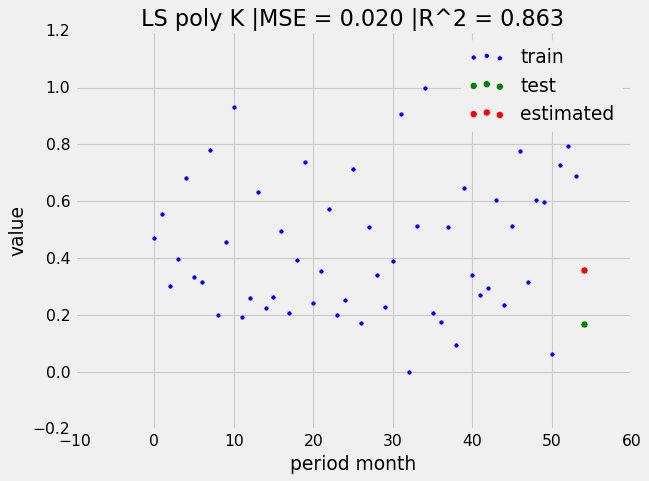

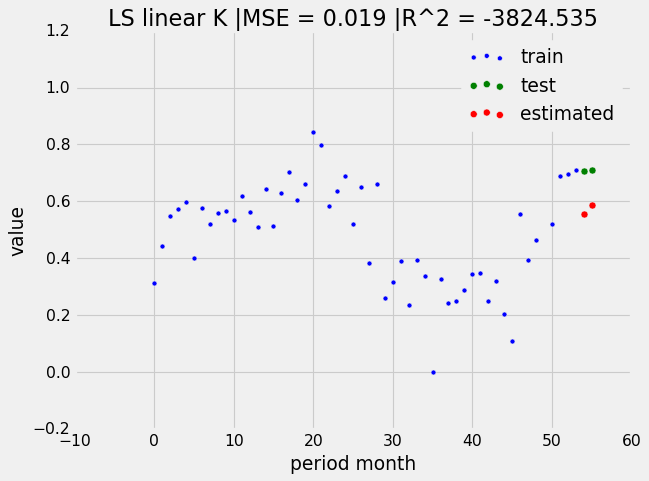

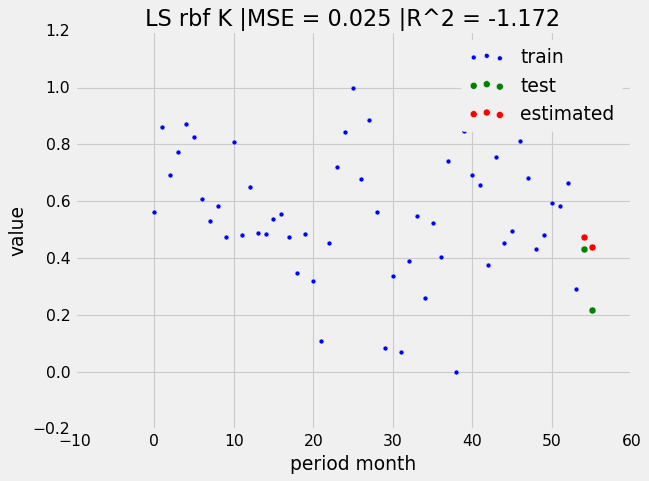

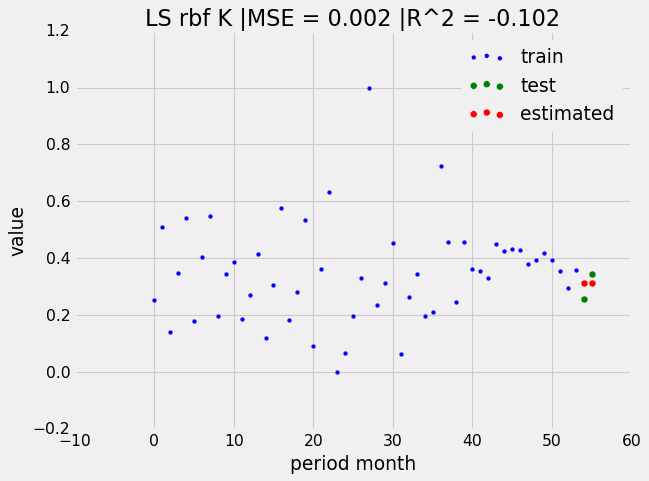

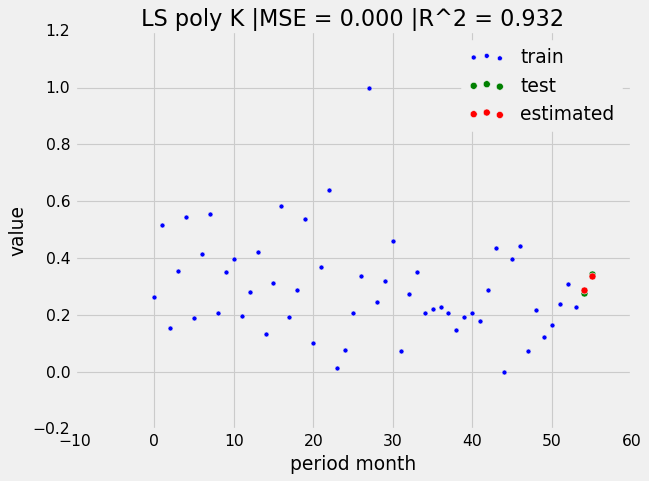

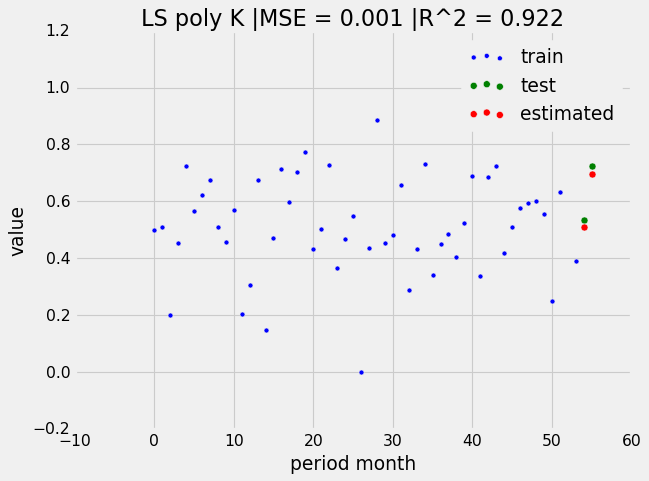

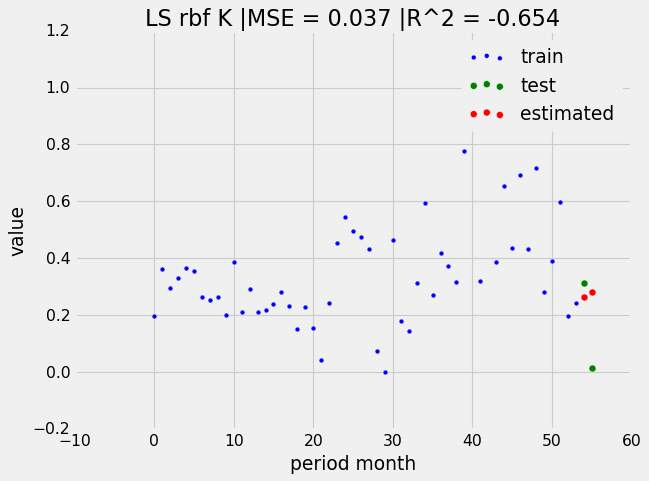

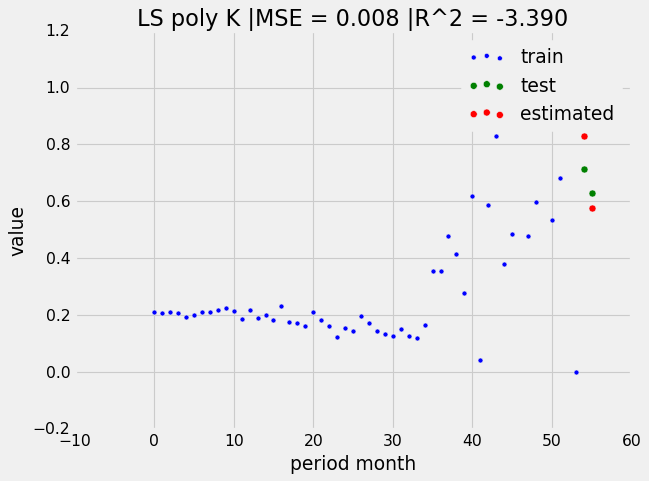

In [144]:
X, y = build_data_sets('CS HQ Owned and Allocated')
_, _, _, _ = compare_svr(X, y, 2,'poly', 0.1, 'auto', 2, 'Yes')

X, y = build_data_sets('Contact Center Expense')
_, _, _, _ = compare_svr(X, y, 2,'linear', 0.1, 'auto', 2, 'Yes')

X, y = build_data_sets('Delivery')
_, _, _, _ = compare_svr(X, y, 2,'rbf', 0.1, 'auto', 2, 'Yes')

X, y = build_data_sets('Delivery OH')
_, _, _, _ = compare_svr(X, y, 2,'rbf', 0.1, 'auto', 2, 'Yes')

X, y = build_data_sets('GBU Owned and Allocated')
_, _, _, _ = compare_lssvm(X, y, 2, 'poly', 1, 2, 'Yes')

X, y = build_data_sets('Net Revenues')
_, _, _, _ = compare_svr(X, y, 2,'poly', 0.1, 'auto', 2, 'Yes')

X, y = build_data_sets('Supply Chain')
_, _, _, _ = compare_svr(X, y, 2,'rbf', 0.1, 'auto', 2, 'Yes')

X, y = build_data_sets('Supply Chain OH')
_, _, _, _ = compare_lssvm(X, y, 2, 'poly', 1, 2, 'Yes')

## Discusión de resultados

Indiscutiblemente el kernel polinomial es el modelo que regresa los mejores resultados sin importar la formulación. La formulación LS-SVM con kernel polinomial regresa un ajuste perfecto.
El kernel lineal y el radial funciona bien dependiendo de la cuenta, a veces tiene mejores resultados el lineal y a veces el radial. La formulación SVM regresa mejores resultados que LS - SVM para estos dos kernels.

El problema observado con todos es al momento de extrapolar y dados los resultados con los datos de prueba, hay modelos que entregaron un $R^2$ negativo.

Para tener resultados en los valores originales solo es necesario utilizar la función *inverse_transform()* de la clase *MinMaxScaler*. Los resultados seran los mismos solo que a una escala mayor.

In [161]:
#data split
acc = 'GBU Owned and Allocated'
test_window = 2

y = data[acc].values[1:]
y = y.ravel()

X_others = data[list(set(data.columns) - set(acc))].values[:-1,:]
X_q = [1 if x%3 == 0 else 0 for x in range(len(X_periods))]
X_q = np.array(X_q[1:])
X = np.column_stack((X_periods[1:], X_others, X_q))


X_train = X[:-test_window]
X_test = X[len(X) - test_window:]
y_train = y[:-test_window]
y_test = y[len(y) - test_window:]

scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

# creating a SVR model class
model_svr = SVR(kernel='poly', gamma=1, degree=3, epsilon=2, C=0.5)
# Training the model
model_svr.fit(X_train, y_train)


SVR(C=0.5, epsilon=2, gamma=1, kernel='poly')

In [162]:
import pickle
with open('model.pkl', 'wb') as model_file:
  pickle.dump(model_svr, model_file)


## Referencias

- sklearn. (n.d.). sklearn.svm.SVR. Scikit-Learn. Retrieved May 6, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

- Danny, V. (2020, August 19). Building your own scikit-learn Regressor-Class: LS-SVM as an example. The Delocalized Physicist. Retrieved April 30, 2022, from https://dannyvanpoucke.be/building-scikit-learn-regressor-lssvm-en/